
# **Sistem Rekomendasi**: Rekomendasi Film menggunakan Content Based Filter 

##### Oleh : Muhammad Rionando D
##### Proyek Submission 2 - Machine Learning Terapan Dicoding

# **Pendahuluan**

Pada proyek ini, topik yang dibahas adalah mengenai sistem rekomendasi content based filter menggunakan dataset film yang bersumber dari kaggle

# **1. Mengimpor modul yang dibutuhkan**

In [1]:
# Untuk pengolahan data
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import json

# Untuk visualisasi data
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import iplot
import missingno as msno

# Untuk pembuatan sistem rekomendasi 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# **2. Mempersiapkan Dataset**

In [2]:
#install kaggle library 
!pip install kaggle

In [3]:
#upload file kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muahammadrionandod","key":"d0c9f1dfec82f6af90fcc9cc62f00bc5"}'}

In [4]:
#kaggle setup
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [5]:
#upload dataset 
!kaggle datasets download -d tmdb/tmdb-movie-metadata

100% 8.89M/8.89M [00:01<00:00, 8.91MB/s]



In [6]:
#mengekstrak dataset
!unzip /content/tmdb-movie-metadata.zip

Archive:  /content/tmdb-movie-metadata.zip
  inflating: tmdb_5000_credits.csv   
  inflating: tmdb_5000_movies.csv    


# **3. Data Understanding** 

## 3.1 Memuat Data pada sebuah Dataframe menggunakan *pandas*

In [7]:
#memuat dataset dan menampilkan data sekilas
df_movies = pd.read_csv("/content/tmdb_5000_movies.csv")
df_credits = pd.read_csv("/content/tmdb_5000_credits.csv")
df_movies.head(10)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
5,258000000,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""na...",http://www.sonypictures.com/movies/spider-man3/,559,"[{""id"": 851, ""name"": ""dual identity""}, {""id"": ...",en,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,115.699814,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-01,890871626,139.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,The battle within.,Spider-Man 3,5.9,3576
6,260000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...",http://disney.go.com/disneypictures/tangled/,38757,"[{""id"": 1562, ""name"": ""hostage""}, {""id"": 2343,...",en,Tangled,When the kingdom's most wanted-and most charmi...,48.681969,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2010-11-24,591794936,100.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,They're taking adventure to new lengths.,Tangled,7.4,3330
7,280000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://marvel.com/movies/movie/193/avenge

In [8]:
df_credits.head(10)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
5,559,Spider-Man 3,"[{""cast_id"": 30, ""character"": ""Peter Parker / ...","[{""credit_id"": ""52fe4252c3a36847f80151a5"", ""de..."
6,38757,Tangled,"[{""cast_id"": 34, ""character"": ""Flynn Rider (vo...","[{""credit_id"": ""52fe46db9251416c91062101"", ""de..."
7,99861,Avengers: Age of Ultron,"[{""cast_id"": 76, ""character"": ""Tony Stark / Ir...","[{""credit_id"": ""55d5f7d4c3a3683e7e0016eb"", ""de..."
8,767,Harry Potter and the Half-Blood Prince,"[{""cast_id"": 3, ""character"": ""Harry Potter"", ""...","[{""credit_id"": ""52fe4273c3a36847f801fab1"", ""de..."
9,209112,Batman v Superman: Dawn of Justice,"[{""cast_id"": 18, ""character"": ""Bruce Wayne / B...","[{""credit_id"": ""553bf23692514135c8002886"", ""de..."


## 3.2 Uraian variabel pada dataset

In [9]:
#Memuat informasi dataframe
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [10]:
#memuat info data frame
df_credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4803 non-null   int64 
 1   title     4803 non-null   object
 2   cast      4803 non-null   object
 3   crew      4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB


In [11]:
#melihat kolom
df_movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [12]:
#melihat kolom
df_credits.columns

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')

In [13]:
# Menghitung null pada setiap kolom
df_movies.isna().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

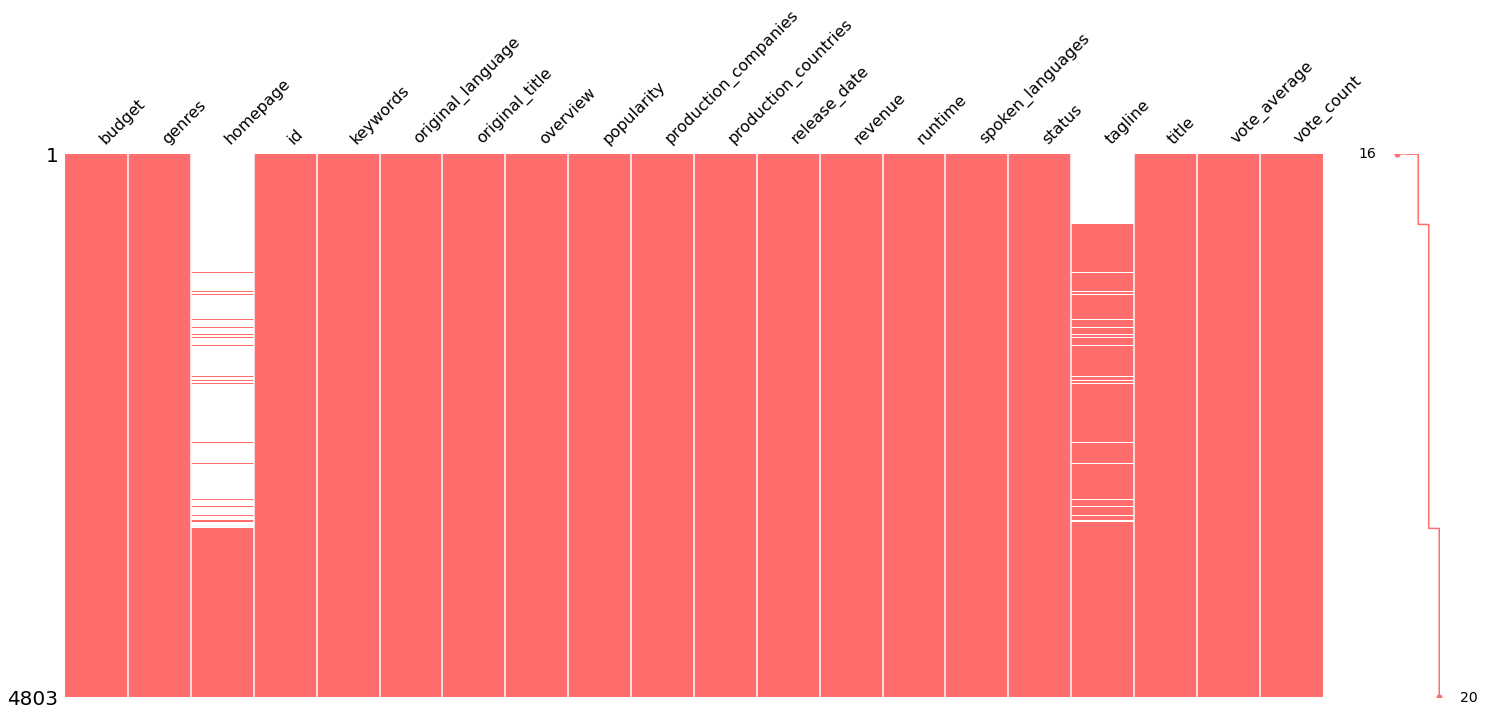

In [14]:
# Memvisualisasikan data kosong pada setiap kolom
sorted_null = msno.nullity_sort(df_movies, sort='ascending') 
figures = msno.matrix(sorted_null, color=(1, 0.43, 0.43))

In [15]:
#mendiskripsikan dataframe
df_movies.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [16]:
#mendiskripsikan dataframe
df_credits.describe()

,movie_id
count,4803.000000
mean,57165.484281
std,88694.614033
min,5.000000
25%,9014.500000
50%,14629.000000
75%,58610.500000
max,459488.000000


In [17]:
#mengetahui jumlah dataset
print(df_credits.shape)
print(df_movies.shape)

(4803, 4)
(4803, 20)


# **4. Data Preperation dan EDA** 

Mengubah data dari json ke string untuk visualisasi

In [18]:
# mengubah kolom genres dari json ke string
df_movies['genres'] = df_movies['genres'].apply(json.loads)
for index,i in zip(df_movies.index,df_movies['genres']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name'])) 
    df_movies.loc[index,'genres'] = str(list1)

# mengubah kolom keywoard dari json ke string
df_movies['keywords'] = df_movies['keywords'].apply(json.loads)
for index,i in zip(df_movies.index,df_movies['keywords']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    df_movies.loc[index,'keywords'] = str(list1)
    
# mengubah kolom  production_companies dari json ke string
df_movies['production_companies'] = df_movies['production_companies'].apply(json.loads)
for index,i in zip(df_movies.index,df_movies['production_companies']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    df_movies.loc[index,'production_companies'] = str(list1)

# mengubah kolom cast dari json ke string
df_credits['cast'] = df_credits['cast'].apply(json.loads)
for index,i in zip(df_credits.index,df_credits['cast']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    df_credits.loc[index,'cast'] = str(list1)

# mengubah kolom crew dari json ke string   
df_credits['crew'] = df_credits['crew'].apply(json.loads)
def director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
df_credits['crew'] = df_credits['crew'].apply(director)
df_credits.rename(columns={'crew':'director'},inplace=True)

## 4.1 Menggabungkan dataset dan Drop variabel 

In [19]:
# mengganti nama kolom movie_id menjadi id
credits_renamed=df_credits.rename(index=str,columns={'movie_id':'id'})
credits_renamed.head()

,id,title,cast,director
0,19995,Avatar,"['Sam Worthington', 'Zoe Saldana', 'Sigourney ...",James Cameron
1,285,Pirates of the Caribbean: At World's End,"['Johnny Depp', 'Orlando Bloom', 'Keira Knight...",Gore Verbinski
2,206647,Spectre,"['Daniel Craig', 'Christoph Waltz', 'Léa Seydo...",Sam Mendes
3,49026,The Dark Knight Rises,"['Christian Bale', 'Michael Caine', 'Gary Oldm...",Christopher Nolan
4,49529,John Carter,"['Taylor Kitsch', 'Lynn Collins', 'Samantha Mo...",Andrew Stanton


In [20]:
# Meenggabungkan dataset
movie=df_movies.merge(credits_renamed,on='id')
movie.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,director
0,237000000,"['Action', 'Adventure', 'Fantasy', 'Science Fi...",http://www.avatarmovie.com/,19995,"['culture clash', 'future', 'space war', 'spac...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"['Ingenious Film Partners', 'Twentieth Century...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"['Sam Worthington', 'Zoe Saldana', 'Sigourney ...",James Cameron
1,300000000,"['Adventure', 'Fantasy', 'Action']",http://disney.go.com/disneypictures/pirates/,285,"['ocean', 'drug abuse', 'exotic island', 'east...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"['Walt Disney Pictures', 'Jerry Bruckheimer Fi...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"['Johnny Depp', 'Orlando Bloom', 'Keira Knight...",Gore Verbinski
2,245000000,"['Action', 'Adventure', 'Crime']",http://www.sonypictures.com/movies/spectre/,206647,"['spy', 'based on novel', 'secret agent', 'seq...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"['Columbia Pictures', 'Danjaq', 'B24']","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"['Daniel Craig', 'Christoph Waltz', 'Léa Seydo...",Sam Mendes
3,250000000,"['Action', 'Crime', 'Drama', 'Thriller']",http://www.thedarkknightrises.com/,49026,"['dc comics', 'crime fighter', 'terrorist', 's...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"['Legendary Pictures', 'Warner Bros.', 'DC Ent...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"['Christian Bale', 'Michael Caine', 'Gary Oldm...",Christopher Nolan
4,260000000,"['Action', 'Adventure', 'Science Fiction']",http://movies.disney.com/john-carter,49529,"['based on novel', 'mars', 'medallion', 'space...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,['Walt Disney Pictures'],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"['Taylor Kitsch', 'Lynn Collins', 'Samantha Mo...",Andrew Stanton


In [21]:
# Membuang kolom yang tidak digunakan
movies=movie.drop(columns=['homepage','title_x','title_y','status','production_countries'])
movies.head()

,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,cast,director
0,237000000,"['Action', 'Adventure', 'Fantasy', 'Science Fi...",19995,"['culture clash', 'future', 'space war', 'spac...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"['Ingenious Film Partners', 'Twentieth Century...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Enter the World of Pandora.,7.2,11800,"['Sam Worthington', 'Zoe Saldana', 'Sigourney ...",James Cameron
1,300000000,"['Adventure', 'Fantasy', 'Action']",285,"['ocean', 'drug abuse', 'exotic island', 'east...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"['Walt Disney Pictures', 'Jerry Bruckheimer Fi...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","At the end of the world, the adventure begins.",6.9,4500,"['Johnny Depp', 'Orlando Bloom', 'Keira Knight...",Gore Verbinski
2,245000000,"['Action', 'Adventure', 'Crime']",206647,"['spy', 'based on novel', 'secret agent', 'seq...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"['Columbia Pictures', 'Danjaq', 'B24']",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",A Plan No One Escapes,6.3,4466,"['Daniel Craig', 'Christoph Waltz', 'Léa Seydo...",Sam Mendes
3,250000000,"['Action', 'Crime', 'Drama', 'Thriller']",49026,"['dc comics', 'crime fighter', 'terrorist', 's...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"['Legendary Pictures', 'Warner Bros.', 'DC Ent...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Legend Ends,7.6,9106,"['Christian Bale', 'Michael Caine', 'Gary Oldm...",Christopher Nolan
4,260000000,"['Action', 'Adventure', 'Science Fiction']",49529,"['based on novel', 'mars', 'medallion', 'space...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,['Walt Disney Pictures'],2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","Lost in our world, found in another.",6.1,2124,"['Taylor Kitsch', 'Lynn Collins', 'Samantha Mo...",Andrew Stanton


## 4.2 EDA

4.2.1 Genres

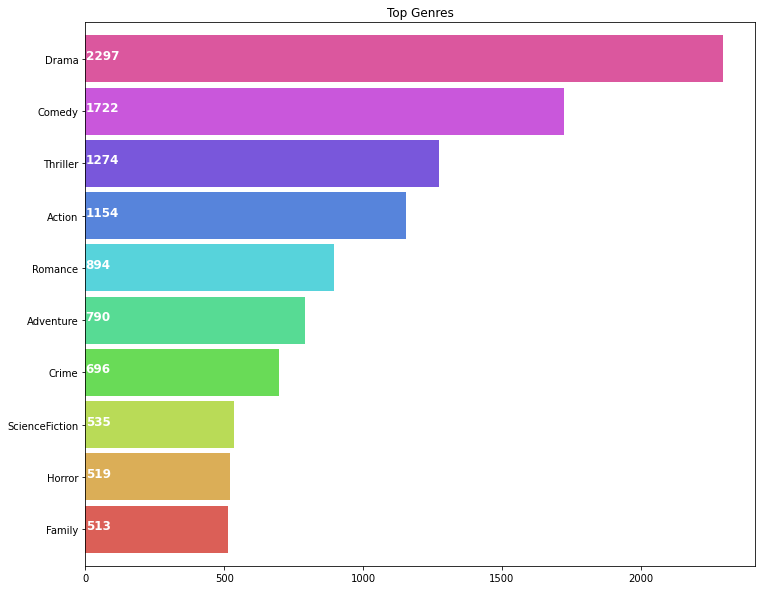

In [22]:
# Visualisasi Genres
movies['genres'] = movies['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['genres'] = movies['genres'].str.split(',')
plt.subplots(figsize=(12,10))
list1 = []
for i in movies['genres']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Genres')
plt.show()

4.2.2 Cast

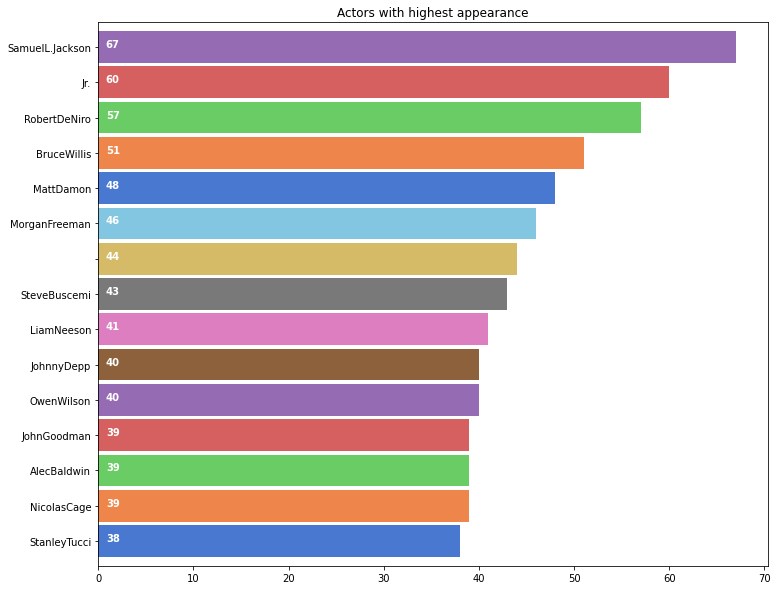

In [23]:
# Visualisasi cast
movies['cast'] = movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies['cast'] = movies['cast'].str.split(',')
plt.subplots(figsize=(12,10))
list1=[]
for i in movies['cast']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(pd.Series(list1).value_counts()[:15].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='white',weight='bold')
plt.title('Actors with highest appearance')
plt.show()

4.2.3 Director

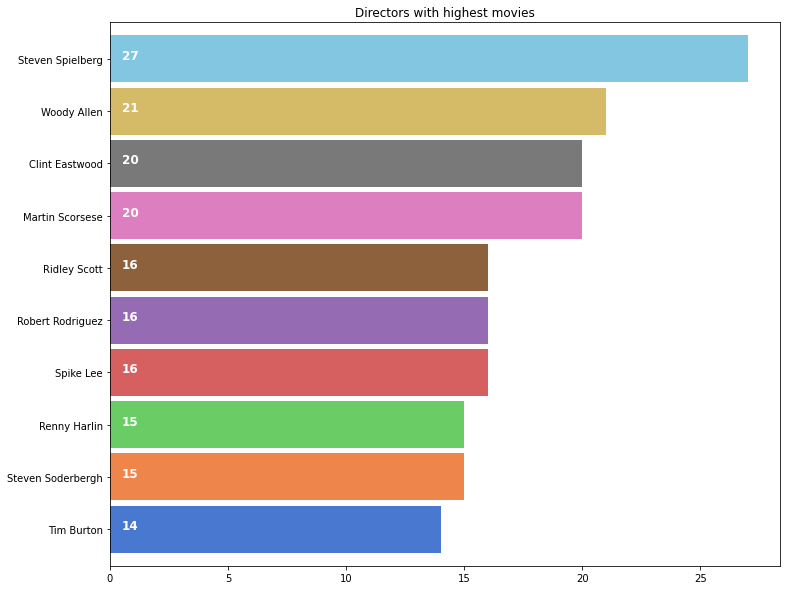

In [24]:
#visualisasi director
def xstr(s):
    if s is None:
        return ''
    return str(s)
movies['director'] = movies['director'].apply(xstr)
plt.subplots(figsize=(12,10))
ax = movies[movies['director']!=''].director.value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(movies[movies['director']!=''].director.value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.5, i, v,fontsize=12,color='white',weight='bold')
plt.title('Directors with highest movies')
plt.show()

## 4.3 Standarisasi

In [25]:
# Memilih semua kolom dengan tipe data integer
column_int = df_movies.dtypes[df_movies.dtypes == 'int64'].keys()
column_int

Index(['budget', 'id', 'revenue', 'vote_count'], dtype='object')

In [26]:
# Memilih semua kolom dengan tipe data float
column_float = df_movies.dtypes[df_movies.dtypes == 'float64'].keys()
column_float

Index(['popularity', 'runtime', 'vote_average'], dtype='object')

In [27]:
# Menyatukan semua kolom dengan tipe data numerik
column_numeric = list(column_int) + list(column_float)
column_numeric

['budget',
 'id',
 'revenue',
 'vote_count',
 'popularity',
 'runtime',
 'vote_average']

In [28]:
# Inisiasi minmaxscaler
scaler = MinMaxScaler()

In [29]:
# Melakukan standarisasi data
scaled = scaler.fit_transform(df_movies[column_numeric])

In [30]:
# Mengganti data numerik dengan data yang sudah
# di standarisasi
i=0
for column in column_numeric:
    df_movies[column] = scaled[:,i]
    i += 1

In [31]:
# Melihat hasil standarisasi data
df_movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,0.623684,"['Action', 'Adventure', 'Fantasy', 'Science Fi...",http://www.avatarmovie.com/,0.043505,"['culture clash', 'future', 'space war', 'spac...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",0.171815,"['Ingenious Film Partners', 'Twentieth Century...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,1.000000,0.479290,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,0.72,0.858057
1,0.789474,"['Adventure', 'Fantasy', 'Action']",http://disney.go.com/disneypictures/pirates/,0.000609,"['ocean', 'drug abuse', 'exotic island', 'east...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",0.158846,"['Walt Disney Pictures', 'Jerry Bruckheimer Fi...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,0.344696,0.500000,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,0.69,0.327225
2,0.644737,"['Action', 'Adventure', 'Crime']",http://www.sonypictures.com/movies/spectre/,0.449727,"['spy', 'based on novel', 'secret agent', 'seq...",en,Spectre,A cryptic message from Bond’s past sends him o...,0.122635,"['Columbia Pictures', 'Danjaq', 'B24']","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,0.315884,0.437870,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,0.63,0.324753
3,0.657895,"['Action', 'Crime', 'Drama', 'Thriller']",http://www.thedarkknightrises.com/,0.106687,"['dc comics', 'crime fighter', 'terrorist', 's...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,0.128272,"['Legendary Pictures', 'Warner Bros.', 'DC Ent...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,0.389151,0.488166,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,0.76,0.662158
4,0.684211,"['Action', 'Adventure', 'Science Fiction']",http://movies.disney.com/john-carter,0.107782,"['based on novel', 'mars', 'medallion', 'space...",en,John Carter,"John Carter is a war-weary, former military ca...",0.050169,['Walt Disney Pictures'],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,0.101916,0.390533,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,0.61,0.154450


# **5. Pembuatan Model Content Based Filtering** 

In [36]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()
 
# Melakukan perhitungan idf pada data cuisine
tf.fit(movies['keywords']) 
 
# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names() 

['11',
 '15th',
 '16th',
 '17th',
 '18th',
 '1910s',
 '1917',
 '1920s',
 '1930s',
 '1940s',
 '1950s',
 '1960s',
 '1970s',
 '1980s',
 '1990s',
 '1992',
 '1995',
 '19th',
 '2000',
 '2001',
 '2002',
 '2079',
 '20th',
 '21st',
 '25th',
 '2nd',
 '3d',
 '51',
 '60s',
 '66',
 '95',
 'abandoned',
 'abandonment',
 'abduction',
 'ability',
 'abolitionist',
 'aboriginal',
 'aborigine',
 'abortion',
 'abraham',
 'abroad',
 'absorbing',
 'absurdism',
 'abuse',
 'abusive',
 'academy',
 'acapella',
 'accent',
 'acceptance',
 'accepting',
 'accident',
 'accidental',
 'accountant',
 'accusal',
 'accusations',
 'accused',
 'acid',
 'acting',
 'action',
 'activism',
 'activist',
 'activity',
 'actor',
 'actors',
 'actress',
 'ad',
 'adaptation',
 'addict',
 'addicted',
 'addiction',
 'address',
 'adhd',
 'admiration',
 'admissions',
 'adolescence',
 'adolescent',
 'adolf',
 'adopted',
 'adoption',
 'adoptive',
 'adrenalin',
 'adrenaline',
 'adult',
 'adultery',
 'adultress',
 'advancement',
 'adventure',

In [37]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(movies['keywords']) 
 
# Melihat ukuran matrix tfidf
tfidf_matrix.shape 

(4803, 7168)

In [38]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [39]:
# Membuat dataframe untuk melihat tf-idf matrix
 
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tf.get_feature_names(),
    index=movies.original_title
).sample(22, axis=1).sample(10, axis=0)

,playground,semiautomatic,sorcerer,poor,butch,antidote,cairo,internet,kkk,racoon,berkeley,torso,shorts,volkswagen,differences,indians,grenade,laxative,garden,shadowing,moustache,nephew
original_title,,,,,,,,,,,,,,,,,,,,,,
Eddie: The Sleepwalking Cannibal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Spiderwick Chronicles,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Entrapment,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
La Marche de l'empereur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Betrayed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alexander,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Egyptian,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Eden Lake,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Los lunes al sol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1.        , 0.01254095, 0.        , ..., 0.01912893, 0.        ,
        0.        ],
       [0.01254095, 1.        , 0.        , ..., 0.02328059, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01912893, 0.02328059, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [44]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa judul
cosine_sim_df = pd.DataFrame(cosine_sim, index=movies['original_title'], columns=movies['original_title'])
print('Shape:', cosine_sim_df.shape)
 
# Melihat similarity matrix pada setiap judul
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (4803, 4803)


original_title,Blood Diamond,Pi,The Kid,Hey Arnold! The Movie,Blow
original_title,,,,,
The Young and Prodigious T.S. Spivet,0.000000,0.0,0.0,0.0,0.000000
#Horror,0.000000,0.0,0.0,0.0,0.000000
The Jerky Boys,0.000000,0.0,0.0,0.0,0.000000
괴물,0.022303,0.0,0.0,0.0,0.000000
Twins,0.000000,0.0,0.0,0.0,0.000000
Red Lights,0.000000,0.0,0.0,0.0,0.000000
Everest,0.000000,0.0,0.0,0.0,0.015449
RoboCop 3,0.000000,0.0,0.0,0.0,0.000000
The Avengers,0.000000,0.0,0.0,0.0,0.017144


In [45]:
def movie_recommendations(original_title, similarity_data=cosine_sim_df, items=movies[['original_title', 'keywords']], k=5):
    """
    Rekomendasi Film berdasarkan kemiripan dataframe
 
    Parameter:
    ---
    original_title : tipe data string (str)
                Judul Film (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan resto sebagai 
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---
 
 
    Pada index ini, kita mengambil k dengan nilai similarity terbesar 
    pada index matrix yang diberikan (i).
    """
 
 
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan    
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,original_title].to_numpy().argpartition(
        range(-1, -k, -1))
    
    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    # Drop judul agar nama jduul yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(original_title, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

In [55]:
#mengecek judul film
movies[movies.original_title.eq('Saving Private Ryan')]

,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,cast,director
628,70000000,"[Drama, History, War]",857,"['war crimes', 'self sacrifice', 'war veteran'...",en,Saving Private Ryan,"As U.S. troops storm the beaches of Normandy, ...",76.041867,"['Paramount Pictures', 'DreamWorks SKG', 'Ambl...",1998-07-24,481840909,169.0,"[{""iso_639_1"": ""cs"", ""name"": ""\u010cesk\u00fd""...",The mission is a man.,7.9,5048,"[TomHanks, MattDamon, VinDiesel, TomSizemore, ...",Steven Spielberg


In [56]:
#mencari rekomendasi film
movie_recommendations('Saving Private Ryan')

,original_title,keywords
0,The Hunting Party,"['civil war', 'spy', 'hotel', 'journalist', 'j..."
1,The Monuments Men,"['world war ii', 'nazis', 'art theft', 'post w..."
2,Hart's War,"['black people', 'world war ii', 'prisoners of..."
3,Unbroken,"['world war ii', 'prisoners of war', 'biograph..."
4,南京!南京!,"['war crimes', 'mass murder', 'war victim', 's..."


# **6. Evaluasi Model Content Based Filtering**

Karena pada kasus ini saya hanya menggunakan 1 model dan model yang digunakan adalah content based filtering menggunakan TF-IDF Vectorizer maka metrics evaluasi yang akan saya gunakan adalah precision dan dikarenakan kita tidak bisa menghitung dengan memanggil library scikit learn karena tidak ada data target/label seperti pada supervised learning. maka saya akan menghitung metrics evaluasinya secara manual

precision pada sistem rekomendasi memiliki rumus = junlah rekomendasi yang relevan/total rekomendasi

dari hasil rekomendasi pada model maka ada 5 dari 5 film yang memiliki kata kunci cerita yang similiar dengan Saving Private Ryan maka metrik evaluasinya adalah 5/5= 1

**Precision = 1**

# **Penutupan**

Model sistem rekomendasi film berdasarkan content based filtering telah selesai dibuat dan model ini dapat digunakan untuk merekomendasikan film berdasarkan dataset yang ada. 


### *Referensi*
  - https://www.kaggle.com/tmdb/tmdb-movie-metadata/code?datasetId=138&sortBy=voteCount&searchQuery=col
  - https://www.kaggle.com/heeraldedhia/movie-ratings-and-recommendation-using-knn
  - https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system#Collaborative-Filtering
  - https://www.kaggle.com/fabiendaniel/film-recommendation-engine
  - https://ieeexplore.ieee.org/abstract/document/9489125/